# Consistency check

Here I check that the time evolution obtained from TEBD is the same as the one from exact diagonalization of the Hamiltonian.

The system is made of $L$ spins with periodic boundary condisitons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
import scipy.sparse.linalg as spa
import scipy.linalg as LA
#import opt_einsum as oe

import quimb as qu
import quimb.tensor as qtn
from itertools import product

In [2]:
### PROBLEM PARAMETERS
L = 8         # chain length
omega = 1     # Rabi frequency
V = 0.1       # B-S interaction strength
#V_ = 1       # subsystem interaction strength
beta = 0.1    # inverse temperature for the bath
dt = 0.01     # time step
T = 10        # total time of the simulation


## Exact simulation

In [3]:
### SOME FUNCTIONS
def pauli_op(sites, L):
    '''Function that creates the Pauli operators.
    Args
    ----
    sites : int
        Sites of the spins being the subsystem S
    L : int
        Total length of the spin chain
    
    Return
    ------
    paulis2 : list[scipy.sparse]
        Components of the basis {Fi}, tensor prodcut of I and pauli, (2**L)x(2**L) sparse matrix
    names_pauli2 : list[str]
        Names for such base states
    '''
    names_pauli2=[] # names of the operators
    paulis2=[]      # actual operators
    for i in names:
        for j in names:
            names_pauli2.append( i + str(sites[0]) + j + str(sites[1]) )
            # tensor product of pauli and identities
            paulis2.append(two_FF(pauli_dict[i], pauli_dict[j], sites[0], sites[1], L))
            
    return paulis2, names_pauli2

def compute_traj2(sites, beta, dt, T):
    ''' Function which generates the trajectories starting from
        random initial states (2 bodies).
        Args
        ----
        sites : list[int]
            Sites of the spins being the subsystem S
        beta : float
            Initial temperature
        dt : float
            Time step
        T : float
            Total time
    '''
    paulis2, names_pauli2 = pauli_op(sites,L)
    nstep = int(T / dt)
    
    # initial conditions
    rho = initial_cond(2)
    
    # computation of pauli expectation value as Tr(pauli*rho)
    for i in range(len(names_pauli2)):
        observables_dict[names_pauli2[i]] = ( paulis2[i].dot(rho).trace() /
                                           rho.trace() ).real # normalizaton bc better safe than sorry
    print(names_pauli2[1:])
    
    # ------------- EVOLUTION -----------------
    
    # coherence vector at t=0, the first term is just identity (see names)
    arr = [[ observables_dict[key] for key in observables_dict.keys() ][1:]]
    print(arr)
    
    temp = [ 0.0 ]
    
    # smarter way to calculate the coherence vector:
    rho_tilde = np.conj(U.T) @ rho @ U                  # matrix
    pa_ti = np.array([pa.toarray() for pa in paulis2])  # vector of matrices
    pauli2_tilde = np.conj(U.T) @ pa_ti @ U
    
    # actual evolution: the density matrix rho_tilde changes over time
    for i in range(1, nstep):
        ee = np.exp(-1j*e*dt*i)  # diagonalized hamiltonian
        rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee) 
        
        trace = lambda k: ( (pauli2_tilde[k]@rho_in).trace() / rho_in.trace()).real
        #trace = lambda k: ((oe.contract( 'ij,ji->', pauli2_tilde[k], rho_in ) ) / rho_in.trace()).real
        obs = [trace(k) for k in range(len( names_pauli2 ) )]
        
        arr.append( obs[1:] )
        time = i*dt
        temp.append( time )
        
    print("finished Time = %s" % T)
    
    return np.asarray(arr[:-1]).astype(np.float32), \
           np.asarray(arr[1:]).astype(np.float32), \
           np.asarray(temp[:-1]).astype(np.float32), \
           np.expand_dims(np.asarray(arr[0]).astype(np.float32), 0), \
           np.expand_dims(np.asarray(arr[-1]).astype(np.float32), 0)

def initial_cond(type):
    '''Function returning the density matrix for
    a given initial condition
    
    Args
    ----
        type : int
            select the type of initial condition
    '''
    if type == 1: 
        print('Initial state: random subsystem and thermal bath\n')
        # creation of the Hamiltonian of the Bath
        H_Rabi_th = H1f(sigma_x, L - 2)
        H_Detuning_th = H1f(nf, L - 2)
        H_int_th = H2srdef(nf, nf, L - 2)
        H_th = ( Omega/2 )*H_Rabi_th + Delta*H_Detuning_th + H_int_th
        # this is the thermalized (normalized) initial condition
        bath = (spa.expm( - beta * H_th))/( spa.expm(-beta * H_th ).diagonal().sum().real )

        # creation of density matrix for the local system (= 2 spins)
        #                  t
        # rho = ( M + i N )  ( M + i N )
        rho_loc = np.array([ np.random.normal() for i in range(16) ]).reshape(4,4) \
                    + 1j*np.array([np.random.normal() for i in range(16)]).reshape(4,4)
        rho_loc = rho_loc.dot(rho_loc.conjugate().transpose())
        rho_loc = rho_loc/rho_loc.trace() # so to have Tr = 1

        # density matrix of the full system
        rho = np.kron(rho_loc, bath.toarray())
        
    elif type == 2:  
        print('Initial state as |up,...,up>\n')   #(see basis for Pauli operators)
        rho = np.zeros((2**L, 2**L))
        rho[0][0] = 1
        
    elif type == 3:
        print('Initial state as |up,down,up,down...>\n')   #(see basis for Pauli operators)
        up = np.array([[1, 0]]).T
        down = np.array([[0, 1]]).T
        
        psi = np.kron(up, down)
        
        for i in range(L-2):
            if i%2==0:
                psi = np.kron(psi, up)
            else:
                psi = np.kron(psi, down)
        
        rho = psi@psi.T
                
    return rho

####################################################################################################

def one_F(mat, position, L): ###One-body operator only fermion!###
    
    ####check the first position####
    if position == 1:
        H=sparse.csc_matrix(mat)
        for i in range(2,L+1):
            H = sparse.kron( H , sparse.eye(2))
    else:
        H =  sparse.eye(2) 
        for i in range(2,L+1):
            if i != position:
                H = sparse.kron( H , sparse.eye(2) )
            elif i == position:
                H = sparse.kron( H ,  sparse.csc_matrix(mat)    )
    return H

def two_FF(mat_F1, mat_F2, position1, position2, L): #### Two-bodies fermionic operators, pos1<pos2 ALWAYS!####
            
    if position1 == 1:
        H   =  sparse.csc_matrix(mat_F1)
        for i in range(1,L):
            if (i+1) != position2:
                H = sparse.kron( H  ,    sparse.eye(2)  )
            elif (i+1) == position2:
                H = sparse.kron( H ,   sparse.csc_matrix(mat_F2)   )
    else:
        H = sparse.eye(2) 
        for i in range(1,L):
            if (i+1) == position1:
                H = sparse.kron( H ,  sparse.csc_matrix(mat_F1) )
            elif (i+1) == position2:
                H = sparse.kron( H ,   sparse.csc_matrix(mat_F2) )
            #elif (i+1) != position1 & (i+1) != position2:
            else:
                H = sparse.kron( H , sparse.eye(2) )
    return H

def H1f(mat_F, L):
    H = one_F(mat_F, 1, L)
    for i in range(2,L+1):
        H += one_F(mat_F, i, L)
    return H

def H1srdef(matF_1, matF_2, L):

    H=two_FF(matF_1, matF_2, 1, L, L) + two_FF(matF_1, matF_2, 1, 2, L)
    return H

def H2srdef(matF_1, matF_2, L):

    H=two_FF(matF_1, matF_2, 2, 3, L)
    for i in range(3,L):
            H += two_FF(matF_1, matF_2, i, i+1, L)
    return H

def H3srdef(matF_1, matF_2, L):

    H=two_FF(matF_1, matF_2, 3, 4, L)
    for i in range(4,L):
            H += two_FF(matF_1, matF_2, i, i+1, L)
    return H

def H3srdef1(matF_1, matF_2, L):

    H=two_FF(matF_1, matF_2, 1, L, L) + two_FF(matF_1, matF_2, 1, 2, L) + two_FF(matF_1, matF_2, 2, 3, L)
    return H

In [4]:
# parameters
Omega = omega
C_def = V
Delta = 0
sites = [1,2]
nstep = int(T / dt)

#**********  BASIC MATRIX DEFINITIONS  **********
# Pauli matrices
sigma_x = np.array([ [ 0. , 1.  ], [ 1.  , 0. ] ])
sigma_z = np.array([ [ 1. , 0.  ], [ 0.  , -1.] ])
sigma_y = np.array([ [ 0. , -1.j], [ 1.j , 0.  ] ])
Id = np.eye(2).astype(np.float64) # identity (just in case)

nf = np.array([ [ 1. , 0.], [ 0. , 0. ] ]) # local fermions number nf = (1 + sz) /2

pauli_dict = {
    'X': sigma_x,
    'Y': sigma_y,
    'Z': sigma_z,
    'I': Id
}
names=['I','X','Y','Z']

# dictionary where to store all the observables
observables_dict = {}

paulis2, names_pauli2 = pauli_op(sites,L)

# creating the Hamiltonian
#H_Rabi_th = H1f(sigma_x, L - 2)
#H_Detuning_th = H1f(nf, L - 2)
#H_int_th = H2srdef(nf, nf, L - 2)
#H_th = ( Omega/2 )*H_Rabi_th + Delta*H_Detuning_th + H_int_th
#bath = (spa.expm( - beta * H_th))/( spa.expm(-beta * H_th ).diagonal().sum().real )

print("Building Hamiltonian for L=%s" %(L))

H_Rabi = H1f(sigma_x, L)
H_Detuning = H1f(nf, L)
H_int = H3srdef(nf, nf, L)
H_def = H3srdef1(nf, nf, L)

H = ( Omega/2 )*H_Rabi + Delta*H_Detuning + H_int + C_def*H_def

e, U = LA.eigh(H.toarray())

Building Hamiltonian for L=8


### Here the actual generation

In [5]:
p_t1, p_t2, t, p_0, p_T = compute_traj2(sites, beta, dt, T)

# organizing the output
paulis2, names_pauli2 = pauli_op(sites,L)

observables = {}

for i, name in zip(p_t1.T, names_pauli2[1:]):   # transpose bc I want time evolution for each observable
    observables[name] = i
            

print("done")
metrics = {'dummy': 0}

Initial state as |up,...,up>

['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']
[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]]
finished Time = 10
done


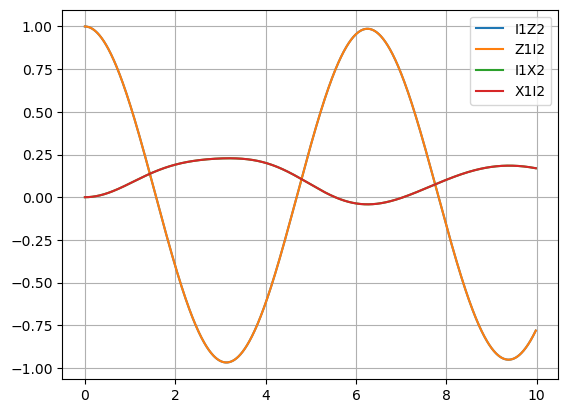

In [7]:
keys = observables.keys()
keys = ['I1Z2', 'Z1I2', 'I1X2', 'X1I2']

for key in keys:
    plt.plot(t, observables[key], label=key)
plt.legend()
plt.grid()

### Simulation using TEBD

In [8]:
### BUILDING THE HAMILTONIAN
# tebd do not require an MPO, but a specification of the local interacting parts of the Hamiltonian

dims = [2]*L # overall space of L qbits

# fisrt I build the operators
X = qu.pauli('X')
Z = qu.pauli('Z')
nn_op = (1 + Z)/2 & (1 + Z)/2

H1 = {i: (omega/2)*X for i in range(L)}
H2 = {None: nn_op, (L-1, 0): V*nn_op, (0, 1): V*nn_op, (1, 2): V*nn_op}

H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)


### BUILDING THE SPIN CHAIN

# binary version of the initial state
# 0 : up
# 1 : down
binary = '01'
for i in range(L-2):
    if i%2==0:
        binary += '0'
    else:
        binary += '1'
binary = '0'*L
print(f'|{binary}>')
        
# turning the state into a MPS
psi = qtn.MPS_computational_state(binary, cyclic=True)
psi.show()  # prints ascii representation of state


|0000000000>
 1 1 1 1 1 1 1 1 1 1 1 
+─●─●─●─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │ │ │ │  


In [14]:
### THE SIMULATION

# first I build the observables
observables_tebd = {}
results = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results[key] = []
    # MPO
    #operators = [qu.pauli(ob1), qu.pauli(ob2)] + [qu.pauli('I')]*(L-2)
    #observables_tebd[key] = qtn.MPO_product_operator(operators, cyclic=True)
    # gate
    observables_tebd[key] = qu.pauli(ob1) & qu.pauli(ob2)

# dropping the identity
observables_tebd.pop('I1I2')
results.pop('I1I2')
    
# create the object
tebd = qtn.TEBD(psi, H)

# I can either set a timestep or a tolerance and the timestep is calculated accordingly
tebd.split_opts['cutoff'] = 1e-10

# generate the state at each time in t (same as exact simulation)
#     and target error 1e-3 for whole evolution
t_ = np.linspace(0, T, 100)
keys = results.keys()
for psit in tebd.at_times(t_, tol=1e-3):
    #for key in keys:
        #results[key].append(qtn.expec_TN_1D(psit.H, observables_tebd[key], psit))
        #results[key].append(psit.H @ psit.gate(observables_tebd[key], (0, 1)))
    results['I1Z2'].append(psit.H @ psit.gate(qu.pauli('Z'), 1))
    results['I1X2'].append(psit.H @ psit.gate(qu.pauli('X'), 1))
    results['Z1I2'].append(psit.H @ psit.gate(qu.pauli('Z'), 0))
    results['X1I2'].append(psit.H @ psit.gate(qu.pauli('X'), 0))
    results['Z1Z2'].append(psit.H @ psit.gate(qu.pauli('Z')&qu.pauli('Z'), (0,1)))
    results['Z1X2'].append(psit.H @ psit.gate(qu.pauli('Z')&qu.pauli('X'), (0,1)))

t=10, max-bond=133: 100%|###################################################################################################################################| 100/100 [00:49<00:00,  2.01it/s]


In [10]:
print(f'Check for the normalization: {tebd.pt.H @ tebd.pt}\n')
#print('Check for energy conservation:\n')
#print(f'  start {qtn.expec_TN_1D(psi.H, H, psi)}')
#print(f'  start {qtn.expec_TN_1D(tebd.pt.H, H, tebd.pt)}')

Check for the normalization: (0.9999999987419332-1.119139246836833e-16j)



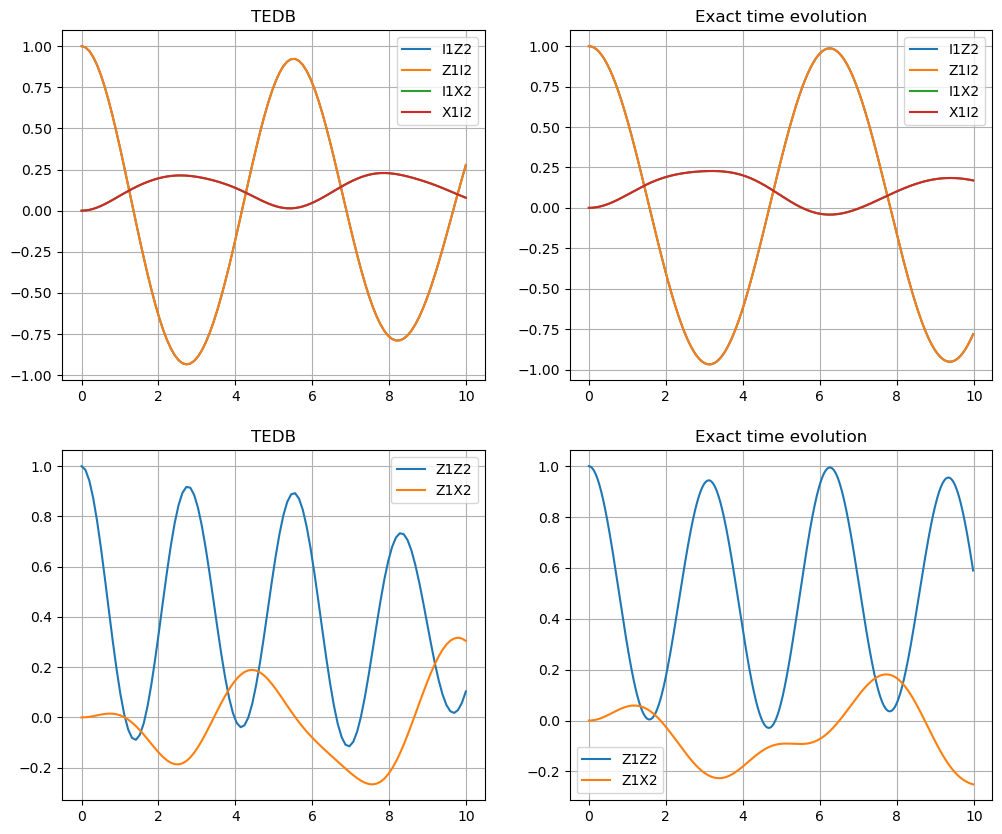

In [19]:
keys = observables_tebd.keys()
keys = ['I1Z2', 'Z1I2', 'I1X2', 'X1I2']

fig, ax = plt.subplots(2, 2, figsize=(12,10))
for key in keys:
    ax[0][0].plot(t_, results[key], label=key)
    ax[0][1].plot(t, observables[key], label=key)    
ax[0][0].set_title('TEDB')
ax[0][1].set_title('Exact time evolution')

keys = ['Z1Z2', 'Z1X2']
for key in keys:
    ax[1][0].plot(t_, results[key], label=key)
    ax[1][1].plot(t, observables[key], label=key)
ax[1][0].set_title('TEDB')
ax[1][1].set_title('Exact time evolution')

for i in range(2):
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend()

{(0,
  1): array([[0.1  +0.j, 0.3  +0.j, 0.3  +0.j, 0.025+0.j],
        [0.3  +0.j, 0.   +0.j, 0.025+0.j, 0.25 +0.j],
        [0.3  +0.j, 0.025+0.j, 0.   +0.j, 0.25 +0.j],
        [0.025+0.j, 0.25 +0.j, 0.25 +0.j, 0.   +0.j]]),
 (1,
  2): array([[0.1  +0.j, 0.3  +0.j, 0.3  +0.j, 0.025+0.j],
        [0.3  +0.j, 0.   +0.j, 0.025+0.j, 0.25 +0.j],
        [0.3  +0.j, 0.025+0.j, 0.   +0.j, 0.25 +0.j],
        [0.025+0.j, 0.25 +0.j, 0.25 +0.j, 0.   +0.j]]),
 (2,
  3): array([[1.  +0.j, 0.75+0.j, 0.75+0.j, 0.25+0.j],
        [0.75+0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j],
        [0.75+0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j],
        [0.25+0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j]]),
 (3,
  4): array([[1.  +0.j, 0.75+0.j, 0.75+0.j, 0.25+0.j],
        [0.75+0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j],
        [0.75+0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j],
        [0.25+0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j]]),
 (4,
  5): array([[1.  +0.j, 0.75+0.j, 0.75+0.j, 0.25+0.j],
        [0.75+0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j],
        [0

In [14]:
L = 44
zeros = '0' * ((L - 2) // 3)
binary = zeros + '1' + zeros + '1' + zeros
print('psi0:', f"|{binary}>")

psi0 = qtn.MPS_computational_state(binary)
psi0.show()  # prints ascii representation of state

H = qtn.ham_1d_heis(L)

tebd = qtn.TEBD(psi0, H)

# Since entanglement will not grow too much, we can set quite
#     a small cutoff for splitting after each gate application
tebd.split_opts['cutoff'] = 1e-12

# times we are interested in
ts = np.linspace(0, 80, 101)

mz_t_j = []  # z-magnetization
be_t_b = []  # block entropy
sg_t_b = []  # schmidt gap

# range of bonds, and sites
js = np.arange(0, L)
bs = np.arange(1, L)

# generate the state at each time in ts
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(ts, tol=1e-3):
    mz_j = []
    be_b = []
    sg_b = []

    # there is one more site than bond, so start with mag
    #     this also sets the orthog center to 0
    mz_j += [psit.magnetization(0)]

    for j in range(1, L):
        # after which we only need to move it from previous site
        mz_j += [psit.magnetization(j, cur_orthog=j - 1)]
        be_b += [psit.entropy(j, cur_orthog=j)]
        sg_b += [psit.schmidt_gap(j, cur_orthog=j)]

    mz_t_j += [mz_j]
    be_t_b += [be_b]
    sg_t_b += [sg_b]

psi0: |00000000000000100000000000000100000000000000>
     1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1    
... >─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─ ...
    │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │     
                                 ...                                  
     1 1 1 1 1 1 1 1 
    >─>─>─>─>─>─>─>─<
    │ │ │ │ │ │ │ │ │


t=80, max-bond=15: 100%|####################################################################################################################################################################################################| 101/101 [03:15<00:00,  1.94s/it]


In [15]:
tebd.pt.show()

     2 4 5 6 7 8 9 10 11 12 13 14 14 14 15 14 14 15 14 14 14 15 15 15 14 1    
... >─>─>─>─>─>─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>─ ...
    │ │ │ │ │ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │     
                                 ...                                  
    5 14 14 14 15 14 14 13 12 11 10 9 8 7 6 5 4 2 
    ─>──>──>──>──>──>──>──>──>──>──>─>─>─>─>─>─>─●
     │  │  │  │  │  │  │  │  │  │  │ │ │ │ │ │ │ │


In [ ]:
    
def one_F(mat, position, L):
    ''' Function creating the one-body fermionic operator.
        Args:
            mat      : 2x2 matrix representation of the fermion operator
            position : position of the fermion in the chain
            L        : length of the chain
        Return:
            tensor product of mat @ position and L-1 identities,
            (2**L)x(2**L) sparse matrix.
        '''
    if position == 1:
        # since H is a sparse matrix, we use:
        H = sparse.csc_matrix(mat)
        # adding tensor product of I
        for i in range(2, L+1):
            H = sparse.kron(H, sparse.eye(2))
    else:
        H = sparse.eye(2)
        for i in range(2, L+1):
            if i != position:
                H = sparse.kron(H, sparse.eye(2))
            elif i == position:
                H = sparse.kron(H, sparse.csc_matrix(mat))
    return H

def two_FF(mat_F1, mat_F2, position1, position2, L):
    ''' Function creating the two-bodies fermionic operator.
        NOTE: pos1 < pos2 ALWAYS!
        Args
        ----
            mat_F1    : matrix representation first fermion
            mat_F2    : matrix representation second fermion
            position1 : position of the first fermion
            position2 : position of the second fermion
            L         : length of the chain
        Return:
            tensor product of mat_F1 @ position1, mat_F2 @ position2 and
            identities that fill the other positions.
            (2**L)x(2**L) sparse matrix.
    '''
    # checkin the positions:
    if position1 > position2:
        raise ValueError('position1 < position2 must be true!')

    if position1 == 1:
        # since H is a psarse matrix we use:
        H = sparse.csc_matrix(mat_F1)
        for i in range(1, L):
            if (i+1) != position2:
                H = sparse.kron(H, sparse.eye(2))
            elif (i+1) == position2:
                H = sparse.kron(H, sparse.csc_matrix(mat_F2))
    else:
        H = sparse.eye(2) 
        for i in range(2, L+1):
            if i == position1:
                H = sparse.kron(H, sparse.csc_matrix(mat_F1))
            elif i == position2:
                H = sparse.kron(H, sparse.csc_matrix(mat_F2))
            else:
                H = sparse.kron(H, sparse.eye(2))
    return H

def H1f(mat_F, L):
    ''' Single fermion hamiltonian:
        sum of mat_F for all L spins in the chain
    '''
    # initialization
    H = sparse.csc_matrix((2**L, 2**L))
    # creation
    for i in range(1, L+1):
        H += one_F(mat_F, i, L)
    return H


def H2srdef(matF_1, matF_2, L):
    ''' Fermions Hamiltonian with pairwise short-range
        (=first-neighbours) interaction,
        starting from fermion #2
    '''
    # initialization
    H = sparse.csc_matrix((2**L, 2**L))
    # creation
    for i in range(2, L):
        H += two_FF(matF_1, matF_2, i, i+1, L)
    return H

def H3srdef(matF_1, matF_2, L):
    ''' Fermions Hamiltonian with pairwise short-range
        (=first-neighbours) interaction
        starting from fermion #3
    '''
    # initialization
    H = sparse.csc_matrix((2**L, 2**L))
    # creation
    for i in range(4, L):
        H += two_FF(matF_1, matF_2, i, i+1, L)
    return H

def H1srdef(matF_1, matF_2, L):

    H = two_FF(matF_1, matF_2, 1, L, L) + two_FF(matF_1, matF_2, 1, 2, L)
    return H

def H3srdef1(matF_1, matF_2, L):

    H = two_FF(matF_1, matF_2, 1, L, L) + two_FF(matF_1, matF_2, 1, 2, L) + two_FF(matF_1, matF_2, 2, 3, L)
    return H